In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import (LinearRegression, Ridge, HuberRegressor, RANSACRegressor)
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot
import statsmodels.stats.api as sms
from scipy import stats
from yellowbrick.regressor import PredictionError
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
from yellowbrick.model_selection import ValidationCurve
from sklearn.model_selection import RandomizedSearchCV
import time
from collections import Counter



# Análise Preditiva

Nessa parte do projeto buscamos fazer uma análise preditiva do preço dos carros seminovos a serem vendidos, baseados em suas features.

**Objetivo:** Prever o preço dos carros baseados em suas features.

# Preparação dos dados

In [2]:
df = pd.read_csv("C:/Users/SAMSUNG/OneDrive/Documentos/GitHub/vendas_carros/dados/df_clean.csv")

In [3]:
df = df.drop(columns=['region'])


Na fase da preparação dos dados utilizaremos pipelines para:
1. Separar a variável target do resto do dataset
2. Separar os dados entre treino e teste
3. Lidar com as variáveis categóricas através de one hot encoding e hash encoding
4. Normalizar os dados

In [4]:
#funções de ajuda
def get_value_count(data):
    categories = data.value_counts(normalize=True) * 100
    return categories

def num_unique(data):
    unique = data.nunique()
    return unique

In [5]:
colunas_object = df.select_dtypes(include='object').columns
for coluna in colunas_object:
    resultado = num_unique(df[coluna])
    print(f"A  coluna {coluna} tem {resultado} categorias unicas")

A  coluna manufacturer tem 41 categorias unicas
A  coluna model tem 20812 categorias unicas
A  coluna condition tem 6 categorias unicas
A  coluna cylinders tem 8 categorias unicas
A  coluna fuel tem 5 categorias unicas
A  coluna title_status tem 6 categorias unicas
A  coluna transmission tem 3 categorias unicas
A  coluna drive tem 3 categorias unicas
A  coluna type tem 13 categorias unicas
A  coluna paint_color tem 12 categorias unicas
A  coluna state tem 51 categorias unicas


In [6]:
get_value_count(df['model']).head(30)

f-150               1.911212
silverado 1500      1.204437
1500                1.024515
camry               0.762071
silverado           0.744668
accord              0.731476
civic               0.694425
escape              0.681233
2500                0.671970
wrangler            0.665514
altima              0.654567
tacoma              0.633235
explorer            0.605166
grand cherokee      0.596184
mustang             0.535274
corolla             0.534432
equinox             0.469593
cr-v                0.465944
focus               0.441524
fusion              0.440963
corvette            0.430296
malibu              0.421034
rav4                0.412894
tahoe               0.402508
grand caravan       0.400263
outback             0.396894
sonata              0.395491
impala              0.391842
odyssey             0.391842
silverado 2500hd    0.383983
Name: model, dtype: float64

Em relação as variáveis categóricas, trataremos com one hot encode.No One hot encoding, para cada nível categórico, criamos uma nova variável binária 0 ou 1. Como o modelo base será uma regressão linear, eliminaremos uma das dummies para evitar problemas de multicolineariedade perfeita.
Para as variáveis manufacturer e state irei diminuir as categorias de maneira similar ao que fiz na análise econométrica. Preferi eliminar a variável model por ela possuir mais de 2000 categorias únicas.

Irei utilizar o MinMaxScaler para normalizar os dados. Como pretendo trabalhar com algumas regressões que utilizam penalização (LASSO e Ridge), realizarei a normalização em todas as colunas.

In [4]:
df = df.drop(columns=['model'])

#categorizando estados por macro região
estados_nordeste = ['me', 'nh','vt','ma', 'ri', 'ct', 'ny', 'pa', 'nj']
nordeste = 'nordeste'

estados_centro_oeste = ['wi', 'mi', 'il', 'in', 'oh', 'mo', 'sd', 'nd', 'ne', 'ks', 'mn', 'ia']
centro_oeste = 'centro oeste'

estados_sul = ['de', 'md', 'va', 'wv', 'nc', 'sc', 'ga', 'fl', 'ky', 'tn', 'ms', 'al', 'ok', 'tx', 'ar', 'la', 'dc']
sul  = 'sul'

estados_oeste = ['id', 'mt', 'wy', 'nv', 'ut', 'co', 'az', 'nm', 'ca', 'or', 'wa', 'ak', 'hi']
oeste = 'oeste'

df['state'] = df['state'].replace(estados_nordeste, nordeste)
df['state'] = df['state'].replace(estados_centro_oeste, centro_oeste)
df['state'] = df['state'].replace(estados_sul, sul)
df['state'] = df['state'].replace(estados_oeste, oeste )

#categorizando manufacturer
carros = ['volvo', 'mitsubishi', 'mini', 'pontiac', 'jaguar', 'rover', 'porsche', 'saturn', 'mercury', 'alfa-romeo', 'tesla', 'fiat', 'harley-davidson', 'datsun', 'ferrari', 'aston-martin', 'land rover']
others = 'others'
df['manufacturer'] = df['manufacturer'].replace(carros, others)

In [5]:
#separando a variável target 
y = df.loc[:, 'price']
X = df.drop('price', axis=1)

In [6]:
# separando em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [7]:
# Separando as variáveis que receberão one hot encoding e as que receberão normalização
onehot_cols = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'manufacturer', 'state']
normalization_cols = ['year', 'odometer']

# Definindo as etapas do pipeline
steps = Pipeline([
    ('preprocess', ColumnTransformer([
        ('onehot', OneHotEncoder(drop='first', sparse=False), onehot_cols),
        ('normalize', MinMaxScaler(), normalization_cols),
    ], remainder='passthrough')),
])


# Aplicando o pipeline aos dados de treinamento
x_train_preprocessed = steps.fit_transform(x_train)
# Aplicando o pipeline aos dados de teste
x_test_preprocessed = steps.transform(x_test)

#Criando datasets com os dados transformados
## obtendo o nome das colunas
original_columns = list(steps.named_steps['preprocess'].named_transformers_['onehot'].get_feature_names_out(onehot_cols)) + normalization_cols

#fazendo os dataset
x_train_preprocessed_df = pd.DataFrame(x_train_preprocessed, columns=original_columns)
x_test_preprocessed_df = pd.DataFrame(x_test_preprocessed, columns = original_columns)

# Normalizing the target variable y
y_scaler = MinMaxScaler()
y_train_preprocessed = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_preprocessed = y_scaler.transform(y_test.values.reshape(-1, 1))


In [8]:
x_train_preprocessed

array([[0.        , 0.        , 0.        , ..., 0.        , 0.88709677,
        0.09039773],
       [0.        , 1.        , 0.        , ..., 1.        , 0.72580645,
        0.28318571],
       [0.        , 1.        , 0.        , ..., 1.        , 0.70967742,
        0.50336626],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 0.91935484,
        0.29974825],
       [1.        , 0.        , 0.        , ..., 1.        , 0.87096774,
        0.46999867],
       [0.        , 1.        , 0.        , ..., 0.        , 0.88709677,
        0.0417501 ]])

In [12]:
y_train_preprocessed

array([[0.25752184],
       [0.06020147],
       [0.0434454 ],
       ...,
       [0.17856426],
       [0.17592209],
       [0.19726016]])

In [8]:
y_train_preprocessed = y_train_preprocessed.reshape(-1)
y_test_preprocessed = y_test_preprocessed.reshape(-1)

In [14]:
y_train_preprocessed

array([0.25752184, 0.06020147, 0.0434454 , ..., 0.17856426, 0.17592209,
       0.19726016])

# Modelo machine learning

Nos modelos de machine learning, eu dividirei entre regressões e modelos de árvore. Como vimos na análise econométrica e na análise exploratória de dados, este dataset apresenta heterocedasticidade nos resíduos, alguns outliers e sua distribuição não é normal. Esses componentes são violações de hipóteses do modelo de regressão clássico. Essas violaçãoes podem levar o modelo a ficar viesado, resultando em um desempenho preditivo pior. Afinal, com a presença de outliers nos dados ou quando a variável resposta não segue uma distribuição normal, as estimativas resultantes podem não ser mais confiáveis.

A solução, portanto, é usar versões modificadas da regressão linear que abordem especificamente a expectativa de outliers no conjunto de dados, sendo as regressões robustas as mais adequadas para esses casos. Em regressões usaremos a OLS não robusta como baseline, a regressão Ridge, a regressão de Huber e a RANSAC. Também usaremos os modelos de SVM, Random Tree e XGBoost.

- **Regressão Ridge**:

- **Regressão de Huber**: um exemplo de algoritmo de regressão robusta que atribui menos peso às observações identificadas como outliers.

- **RANSAC**: RANSAC (Random Sample Consensus) é um algoritmo não determinístico que tenta separar os dados de treinamento em inliers (que podem estar sujeitos a ruído) e outliers. Em seguida, estima o modelo final usando apenas os inliers.

- **Random Forest**: é um algoritmo de aprendizado de máquina que combina várias árvores de decisão independentes e faz previsões tomando uma média ou votação das previsões individuais das árvores, resultando em um modelo mais robusto e com menor tendência ao overfitting.

- **XGBoost**: XGBoost é um algoritmo de boosting de gradiente extremamente poderoso e eficiente, que utiliza árvores de decisão como estimadores fracos e realiza treinamento iterativo para melhorar o desempenho preditivo em problemas de regressão e classificação.

Para melhorar a previsão do modelo e evitar overfitting, utilizarei cross validation com 5 k-folds. Feito isso, iremos avaliar os modelos através de algumas métricas. As métricas serão os R-quadrado, o MAE, RMSE e o MAD.

- **R-quadrado**: O R-quadrado é uma métrica que mede a proporção da variância total dos dados explicada pelo modelo de regressão, indicando o quão bem as variáveis independentes explicam a variabilidade da variável dependente.
- **MAE**: O MAE é uma métrica que calcula a média dos valores absolutos dos erros entre as previsões do modelo e os valores reais, fornecendo uma medida direta do tamanho médio dos erros de previsão.
- **RMSE**(Raiz do Erro Quadrático Médio): O RMSE é uma métrica usada para avaliar a precisão de modelos de regressão, que calcula a raiz quadrada da média dos quadrados das diferenças entre os valores previstos e os valores reais.
- **MAD** (Erro Absoluto Medio): é uma métrica que calcula a media dos valores absolutos dos erros entre as previsões do modelo e os valores reais, proporcionando uma medida robusta e menos sensível a outliers do tamanho médio dos erros de previsão.


In [9]:
def cross_validation(model, X, y):
    # Scikit-learn K-Fold
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
    
    fold_r2 = []
    fold_MAE= []
    fold_RMSE = []
    fold_MAD =[]
    
    
    for idx, (idx_train, idx_validation) in enumerate(kfold.split(X,y)):
        X_train_split = X[idx_train, :]
        y_train_split = y[idx_train]
        
        model.fit(X_train_split, y_train_split)

        X_validation_split = X[idx_validation, :]
        y_validation_split = y[idx_validation]

        predictions = model.predict(X_validation_split)
        
        r2 = r2_score(y_validation_split, predictions)
        MAE = mean_absolute_error(y_validation_split, predictions)
        RMSE = np.sqrt(mean_squared_error(y_validation_split, predictions))
        MAD =  np.mean(np.abs(y_validation_split - predictions))
        
        fold_r2.append(r2)
        fold_MAE.append(MAE)
        fold_RMSE.append(RMSE)
        fold_MAD.append(MAD)
        
    print(f'Média geral do R2: {np.mean(fold_r2)}')
    print(f'Média geral da MAE: {np.mean(fold_MAE)}')
    print(f'Média geral do RMSE: {np.mean(fold_RMSE)}')
    print(f'Média geral da MAD: {np.mean(fold_MAD)}')    
    
    return fold_r2, fold_MAE, fold_RMSE, fold_MAD

In [16]:
models = [LinearRegression(),  Ridge(alpha=0.1),  HuberRegressor(max_iter=350), RANSACRegressor(random_state=42), RandomForestRegressor(),xgb.XGBRegressor()]


for model in models:
    print(f'Cross-validation for {type(model).__name__}:')
    cross_validation(model,x_train_preprocessed, y_train_preprocessed)
    print('------------------------------------------------------------')

Cross-validation for LinearRegression:
Média geral do R2: 0.6179628388509528
Média geral da MAE: 0.040004748655643234
Média geral do RMSE: 0.059722130570298584
Média geral da MAD: 0.040004748655643234
------------------------------------------------------------
Cross-validation for Ridge:
Média geral do R2: 0.6179628687511066
Média geral da MAE: 0.0400047315419372
Média geral do RMSE: 0.05972212832872299
Média geral da MAD: 0.0400047315419372
------------------------------------------------------------
Cross-validation for HuberRegressor:
Média geral do R2: 0.6050541875235333
Média geral da MAE: 0.03900465222222114
Média geral do RMSE: 0.06072340070641687
Média geral da MAD: 0.03900465222222114
------------------------------------------------------------
Cross-validation for RANSACRegressor:
Média geral do R2: -2.2858997956607273e+20
Média geral da MAE: 161467903.64023316
Média geral do RMSE: 951445300.9142879
Média geral da MAD: 161467903.64023316
-------------------------------------

In [17]:
dados = [
    {"Modelo": "LinearRegression", "R2": 0.6179628388509528, "MAE": 0.040004748655643234, "RMSE": 0.059722130570298584, "MAD": 0.040004748655643234},
    {"Modelo": "Ridge", "R2": 0.6179628687511066, "MAE": 0.0400047315419372, "RMSE": 0.05972212832872299, "MAD": 0.0400047315419372},
    {"Modelo": "HuberRegressor", "R2": 0.6050541875235333, "MAE": 0.03900465222222114, "RMSE": 0.06072340070641687, "MAD": 0.03900465222222114},
    {"Modelo": "RANSACRegressor", "R2": -2.2858997956607273e+20, "MAE": 161467903.64023316, "RMSE": 951445300.9142879, "MAD": 161467903.64023316},
    {"Modelo": "RandomForestRegressor", "R2": 0.8634362967153096, "MAE": 0.016657201209182453, "RMSE": 0.035704024575044166, "MAD": 0.016657201209182453},
    {"Modelo": "XGBRegressor", "R2": 0.8009899991152809, "MAE": 0.026083716193812702, "RMSE": 0.04310273654449514, "MAD": 0.026083716193812702}
]

avaliacao = pd.DataFrame(dados)
pd.options.display.float_format = '{:.3f}'.format

In [18]:
avaliacao

,Modelo,R2,MAE,RMSE,MAD
0,LinearRegression,0.618,0.040,0.060,0.040
1,Ridge,0.618,0.040,0.060,0.040
2,HuberRegressor,0.605,0.039,0.061,0.039
3,RANSACRegressor,-228589979566072725504.000,161467903.640,951445300.914,161467903.640
4,RandomForestRegressor,0.863,0.017,0.036,0.017
5,XGBRegressor,0.801,0.026,0.043,0.026


- Os modelos LinearRegression e Ridge apresentam resultados semelhantes em todas as métricas, com R-2 de aproximadamente 0.618, MAE de aproximadamente 0.040, RMSE de aproximadamente 0.060 e MAD de aproximadamente 0.040. Isso ocorre porque Ridge é uma forma de regularização aplicada à regressão linear. Portanto, os resultados são quase idênticos.
- O modelo de HuberRegressor tem desempenho pior no R2, o que não é surpreendente visto que ele é robusto aos problemas que existem no dataset e que levam a resultados viesados. Ele explica 60% da variação. Seus resultados de MAE e MAD são ligeiramente melhores. Quanto mais perto de 0 o MAE estiver melhor seu resultado. Aqui temos que, em média, as previsões do modelo têm um desvio absoluto médio de aproximadamente 0.039 unidades em relação aos valores reais. O RMSE segue lógica simmilar. O MAD calcula o quão disperso os dados são e o quão distante eles estão, em média, da média. Um valor baixo de MAD siginifica que os dados estão agrupados ao redor da média, indicando um modelo mais confiável e estável.
- O modelo de RANSACRegressor apresenta resultados horríveis, incluindo um R2 negativo. Ele provavelmente esta mal específicado.
- Os modelos de árvore tem resultados melhores, aumentando significativamente o R2 (saindo de 60% nos modelos de regressão para 80% nos modelos de árvore). O MAE, RMSE e MAD também ficam mais próximos de zero. 
- Desses modelos, o RandomForestRegressor tem o melhor desempenho, tanto com o maior valor do R2 quanto com os menores valores de MAE, RMSE e MAD.


## Análise de Resíduos e feature importance

### Análise dos Resíduos

Como o o RandomForestRegressor teve um desempenho superior aos outros modelos, eu vou analisar seus resíduos. A análise de resíduos é um tópico clássico relacionado à modelagem estatística e é frequentemente utilizada para avaliar a adequação de um modelo. Dessa maneira, os resíduos são calculados utilizando-se os dados de treinamento e usados para avaliar se as previssões do modelo se ajustam aos valores observados da variável dependente. Os resíduos também podem nos indicar se o modelo tem erros heterocedásticos ou se são afetados por outliers.

Para a maioria dos modelos, os resíduos devem apresentar um comportamento aleatório com certas propriedades (como, por exemplo, estar concentrados em torno de 0). Se encontrarmos quaisquer desvios sistemáticos do comportamento esperado, eles podem indicar um problema com o modelo (por exemplo, uma variável explicativa omitida ou uma forma funcional incorreta de uma variável incluída no modelo).

Vemos isso no gráfico abaixo:

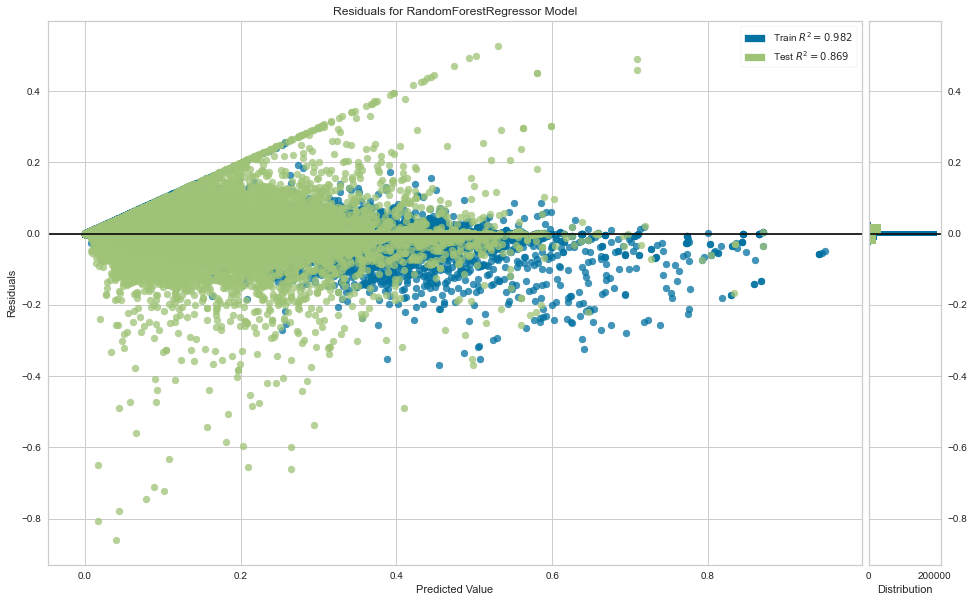

In [19]:

fig, ax = plt.subplots(figsize=(16,10))
rpv = ResidualsPlot(RandomForestRegressor())
rpv.fit(x_train_preprocessed, y_train_preprocessed)
rpv.score(x_test_preprocessed, y_test_preprocessed)
rpv.poof()
plt.show()


Para um modelo "bom", os resíduos devem se desviar aleatoriamente de zero, ou seja, não de forma sistemática. Assim, sua distribuição deve ser simétrica em torno de zero, o que implica que seu valor médio (ou mediano) deve ser zero. Além disso, os resíduos devem ser próximos de zero em si mesmos, ou seja, devem apresentar baixa variabilidade. O gráfico acima mostra a diferença entre os resíduos (valores observados da variável target - valor predito) no eixo Y e a variável dependente no eixo X.  A dispersão no painel superior reflete  o aumento da variabilidade dos resíduos para valores ajustados crescentes. Isso indica uma violação da suposição de homoscedasticidade, ou seja, da constância da variância. Podemos comprovar isto através de um teste estatístico de Breusch–Pagan:

In [20]:
model = RandomForestRegressor()
model_fit = model.fit(x_train_preprocessed, y_train_preprocessed)
y_pred = model_fit.predict(x_test_preprocessed)
resids = y_test_preprocessed - y_pred

hb = sms.het_breuschpagan(resids, x_test_preprocessed)
labels = [
    'Lagrange multiplier statistic',
    'p-value',
    'f-value',
    'f p-value'
]

for name, num in zip(labels, hb):
    print(f'{name}: {num:.2}')

Lagrange multiplier statistic: 2.5e+03
p-value: 0.0
f-value: 3.3e+01
f p-value: 0.0


O valor p é usado para determinar a significância estatística do teste. Neste caso, o valor p é 0.0, o que está abaixo do limite típico de 0.05. Portanto, podemos rejeitar a hipótese nula de homocedasticidade e concluir que há evidências de heterocedasticidade nos resíduos.

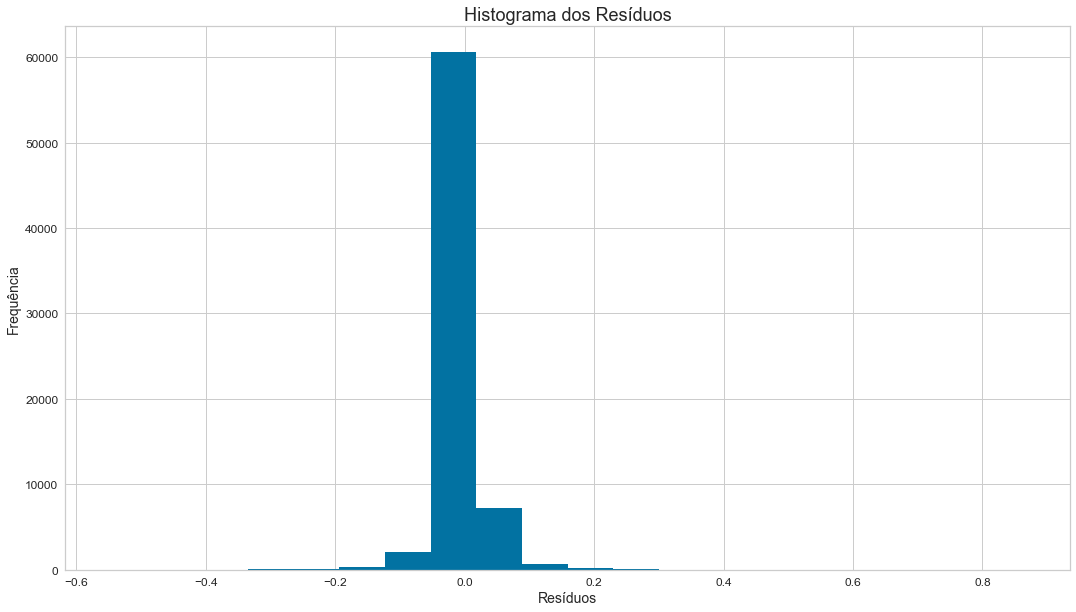

In [21]:
fig, ax = plt.subplots(figsize=(18,10))
resids = y_test_preprocessed - y_pred
pd.Series(resids, name='residuals').plot.hist(bins=20, ax=ax)
plt.title('Histograma dos Resíduos', fontsize=18)
plt.xlabel('Resíduos', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

O histograma dos resíduos mostra que eles se concentram em torno de 0.

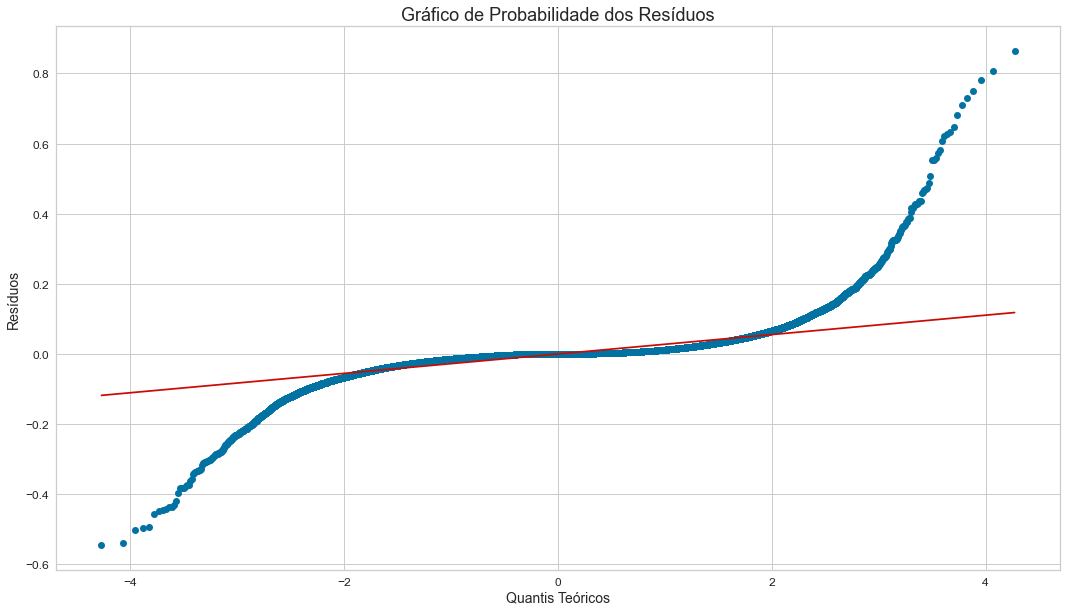

In [22]:
fig, ax = plt.subplots(figsize=(18,10))
_ = stats.probplot(resids, plot=ax)
plt.title('Gráfico de Probabilidade dos Resíduos', fontsize=18)
plt.xlabel('Quantis Teóricos', fontsize=14)
plt.ylabel('Resíduos', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Já o Q-Q plot mostra a normalidade dos resíduos. Se os dados seguirem uma distribuição normal, os pontos dos resíduos irão se sobrepor a reta vermelha que corta o gráfico, ou estarão próximos à ela. Observe que os pontos se alinham ao longo da linha no meio do gráfico, mas se curvam nas extremidades. Os gráficos Q-Q  que exibem esse comportamento geralmente indicam que os dados têm valores mais extremos do que o esperado se eles realmente viessem de uma distribuição normal, esse é o caso do dataset que possui caudas longas.

Confirmamos isto ao utilizar o teste de Kolmogorov-Smirnov:

In [23]:
stats.kstest(resids, cdf='norm')

KstestResult(statistic=0.45262678651390675, pvalue=0.0)

O valor p associado ao teste K-S é 0.0. Esse valor extremamente baixo sugere que há evidência significativa para rejeitar a hipótese nula de que as duas distribuições são iguais. Em outras palavras, indica que as distribuições são estatisticamente diferentes e não temos uma distribuição normal nos dados.

Por fim, fiz um gráfico de erro de previsão mostra os valores reais do conjunto de dados em relação aos valores previstos gerados pelo nosso modelo. Isso nos permite ver quanto de variação há no modelo. 

Ao exibir esses ajustes de linha no gráfico de erro de previsão, o objetivo é comparar visualmente como as previsões do modelo se comparam aos valores reais. O ajuste de linha "identity" ajuda a identificar se o modelo está sub ou superestimando as previsões de maneira sistemática. O ajuste de linha "best fit" indica a tendência geral do modelo e se ele está sub ou superestimando as previsões de maneira consistente. O modelo se ajusta bem para boa parte da amostra, mas perde poder de previsibilidade conforme os valores de y se tornam maiores, subestimando consistentemente os valores reais.

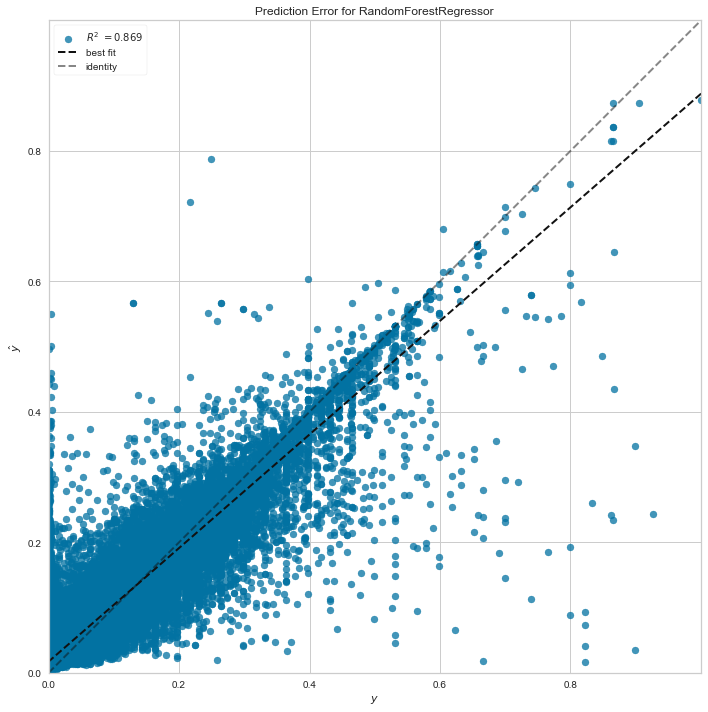

In [24]:
fig, ax = plt.subplots(figsize=(18,12))
pev = PredictionError(model)
pev.fit(x_train_preprocessed, y_train_preprocessed)
pev.score(x_test_preprocessed, y_test_preprocessed)
pev.poof()
plt.show()

### Feature importance

Nessa seção eu me debruço em quais as variáveis o Random Florest considerou mais importate para fazer suas previsões. Saber quais variáveis são importantes e quais não são podem ajudar a otimizar o modelo e diminuir o tempo de convergência. 

Primeiramente, eu plotei uma das árvores de decisão feitas pelo algoritmo de Random Florest para os primeiros 3 níveis, de modo que possamos ter uma noção de como elas se divide. Nela podemos ver que a árvore é decidida por ano, drive_fwd, odômetro e cilindros nos níveis iniciais.

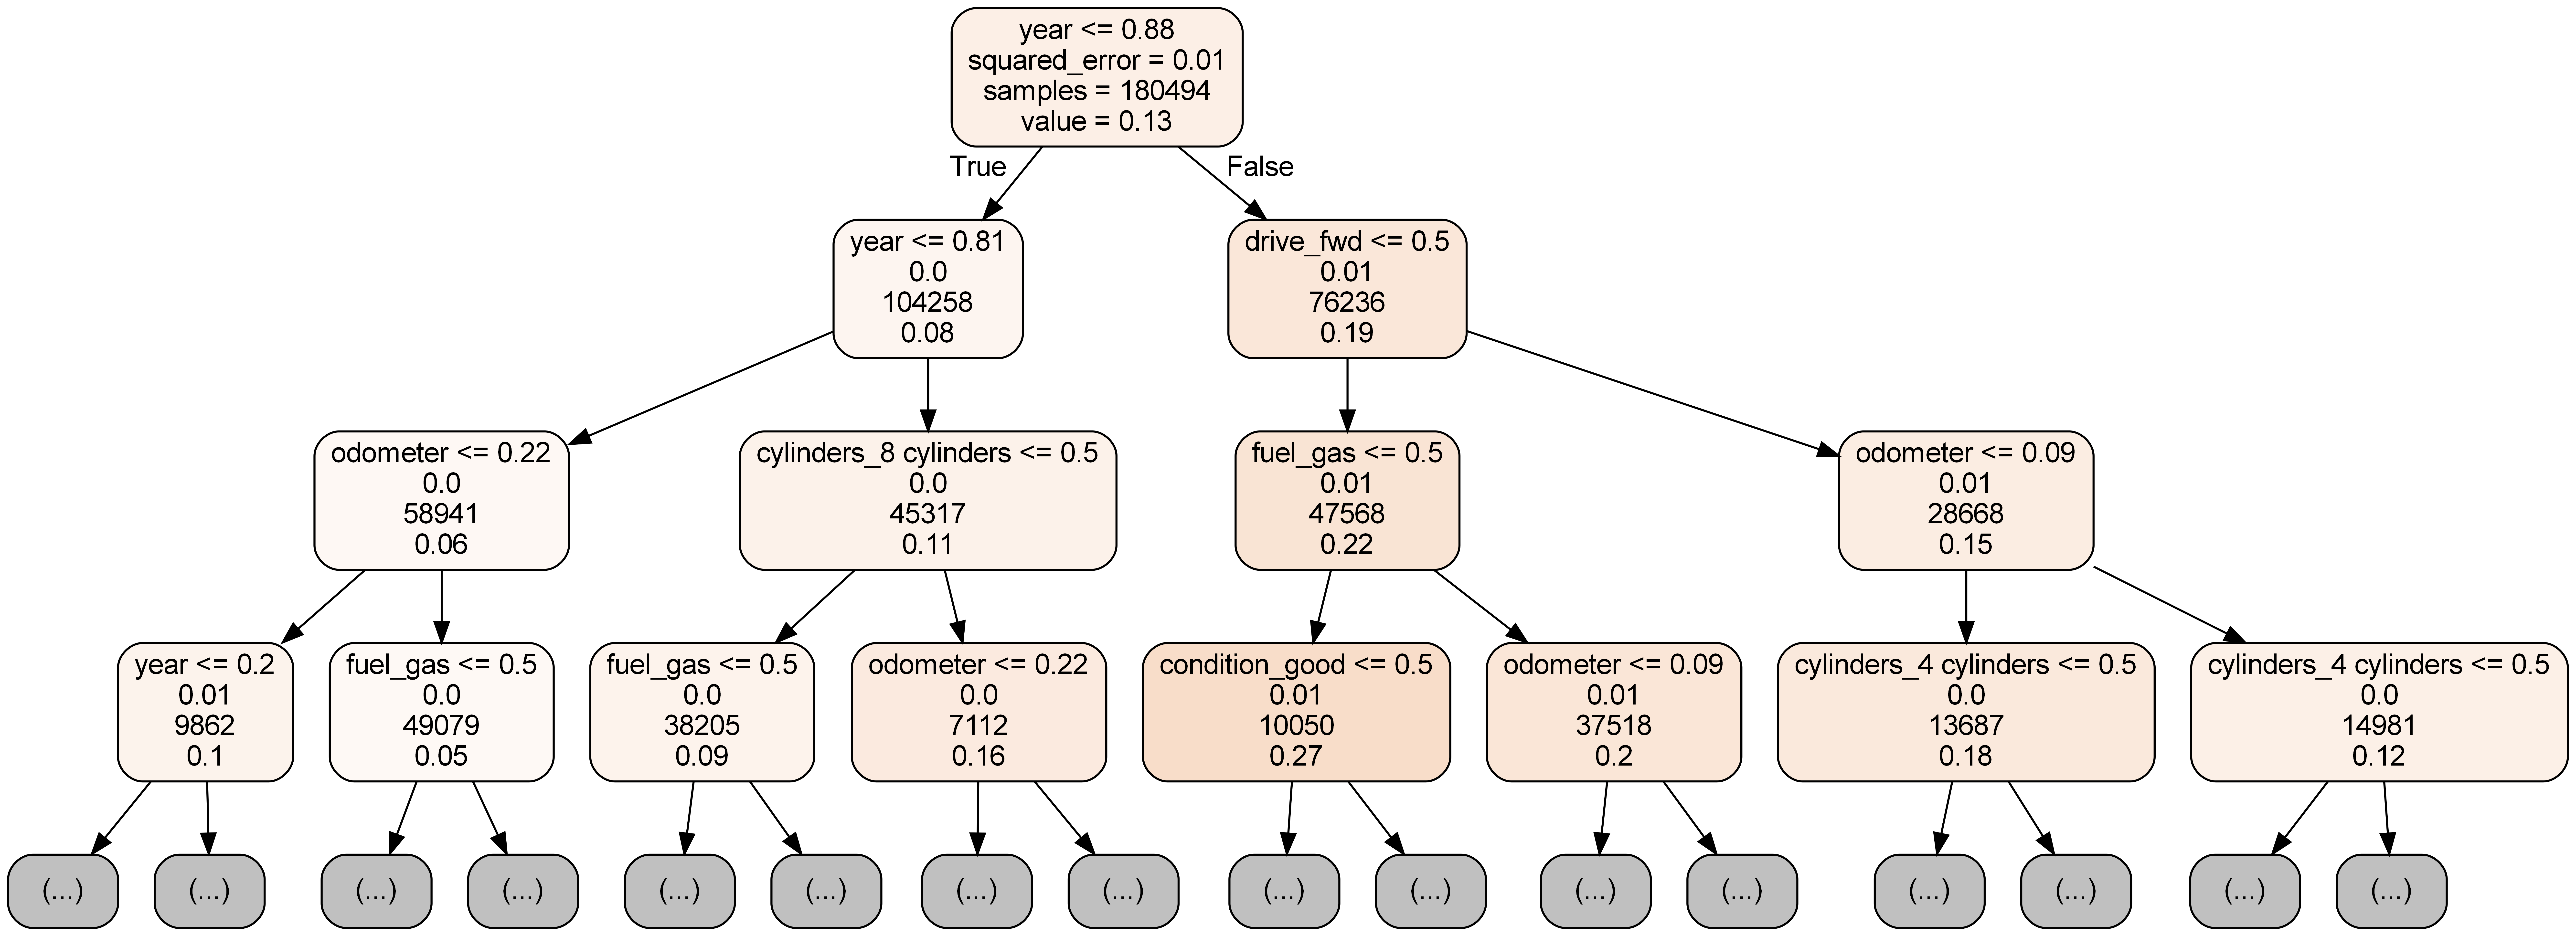

In [25]:
estimator = model.estimators_[5]
export_graphviz(estimator, out_file='tree.dot', 
                max_depth = 3,
                feature_names = x_train_preprocessed_df.columns,
                label= 'root',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
from IPython.display import Image
Image(filename = 'tree.png')

As features importance podem ser obtidas através de um método nativo do algorítimo.Cada Árvore de Decisão é composta por nós internos e folhas. No nó interno, a característica selecionada é usada para tomar uma decisão sobre como dividir o conjunto de dados em dois conjuntos separados com respostas semelhantes. As características para os nós internos são selecionadas com base em algum critério que para regressão é a redução da variância. Podemos medir como cada característica diminui a impureza da divisão (a característica com a maior diminuição é selecionada para o nó interno). Para cada característica, podemos coletar como ela diminui a impureza em média. A média de todas as árvores no conjunto forma a medida da importância da característica. 
A maior vantagem desse método é a velocidade de computação. As desvantagens do método incluem a tendência a selecionar como importantes características numéricas e características categóricas com alta cardinalidade. 

Text(0, 0.5, 'Feature')

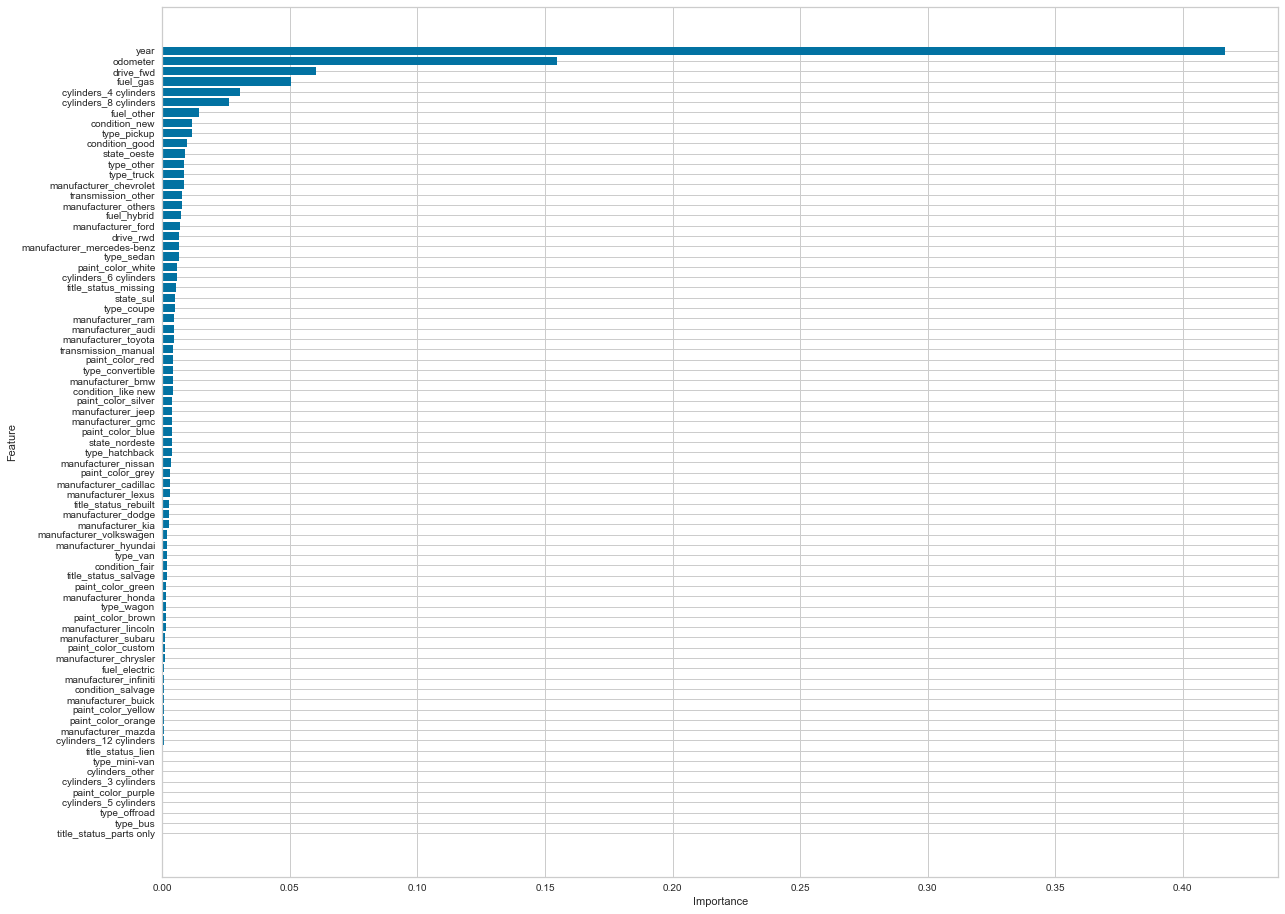

In [26]:
importances = model.feature_importances_
features = x_train_preprocessed_df.columns
indices = np.argsort(importances)[::1]
names = [features[i] for i in indices]
plt.figure(figsize=(20, 16))
plt.barh(range(x_train_preprocessed_df.shape[1]), importances[indices])
plt.yticks(range(x_train_preprocessed_df.shape[1]), names)
plt.xlabel('Importance')
plt.ylabel('Feature')



As variáveis mais importantes aqui reenforçam o que foi visto no plot da árvore de decisão.

Outra maneira de visualizar a importância das features é através de permutação.Ela é utilizada para superar as limitações do método anterior. Este método irá embaralhar aleatoriamente cada característica e calcular a mudança no desempenho do modelo. As características que têm maior impacto no desempenho são as mais importantes.

In [27]:
perm_importance = permutation_importance(model, x_test_preprocessed, y_test_preprocessed)

Text(0, 0.5, 'Feature')

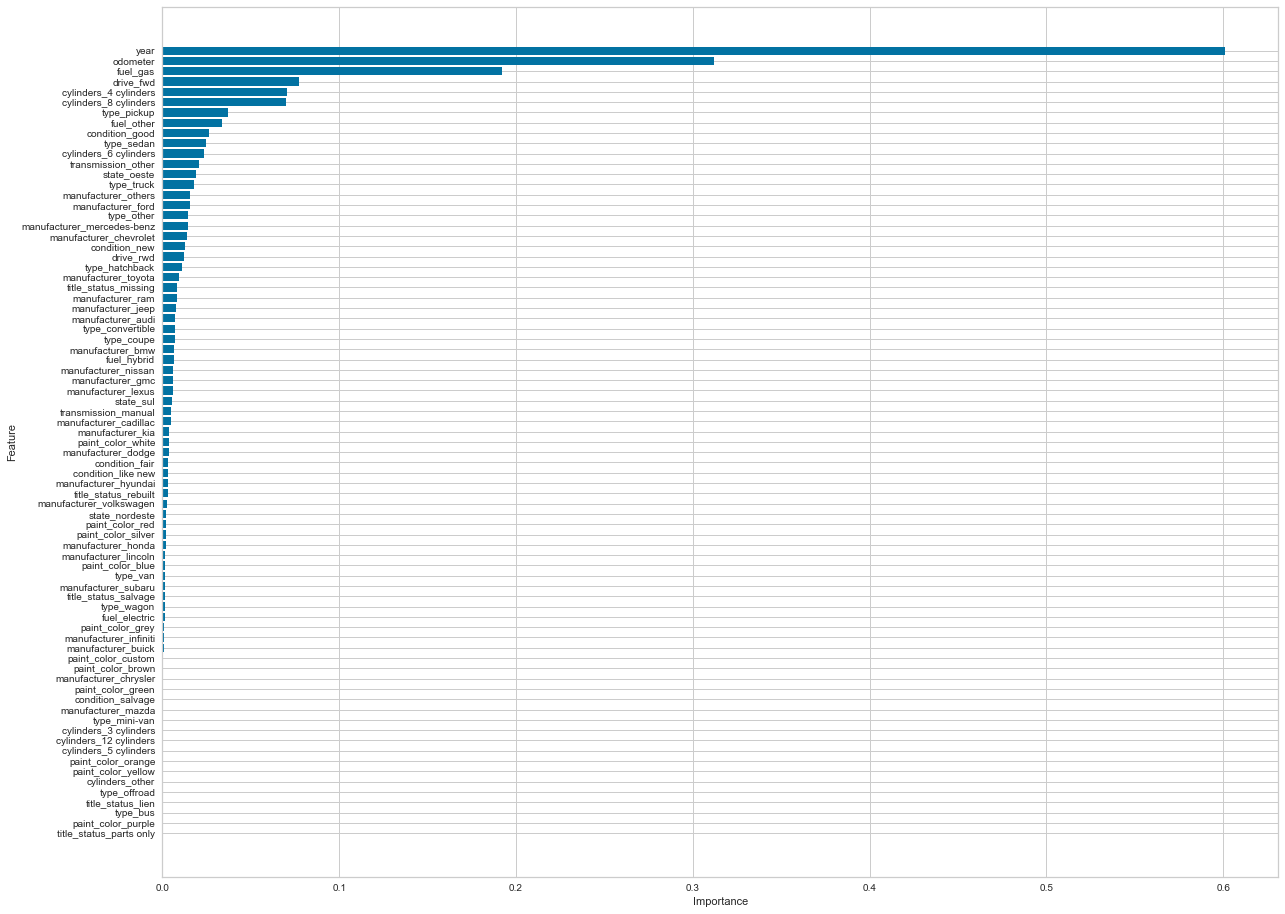

In [28]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(20, 16))

plt.barh(x_train_preprocessed_df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.xlabel('Importance')
plt.ylabel('Feature')

Aqui vemos que basicamente temos os mesmo resultados.

Por fim, utilizaremos o método do SelectFromModel. O SelectFromModel selecionará aquelas características cuja importância seja maior do que a importância média de todas as características por padrão.

In [29]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel.fit(x_train_preprocessed, y_train_preprocessed)

SelectFromModel(estimator=RandomForestRegressor())

Para ver quais características são importantes, podemos usar o método get_support no modelo ajustado. Ele retornará uma matriz de valores booleanos, sendo True para as características cuja importância seja maior que a importância média e False para as demais.

In [30]:
sel.get_support()

array([False, False, False, False, False, False, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True])

In [31]:
selected_feat= x_train_preprocessed_df.columns[(sel.get_support())]
len(selected_feat)

7

In [32]:
print(selected_feat)

Index(['cylinders_4 cylinders', 'cylinders_8 cylinders', 'fuel_gas',
       'fuel_other', 'drive_fwd', 'year', 'odometer'],
      dtype='object')


As características selecionadas com base na importância são: 'cylinders_4 cylinders', 'cylinders_8 cylinders', 'fuel_gas' ,'fuel_other', 'drive_fwd','year','odometer'. Todos os testes de feature importance que fizemos indica que essas são as variáveis mais importantes para o modelo.

# Hyperparameter Tuning

Os hiperparâmetros podem ser pensados como as configurações de um algoritmo que podem ser ajustadas para otimizar o desempenho. Enquanto os parâmetros do modelo são aprendidos durante o treinamento - como a inclinação e o intercepto em uma regressão linear - os hiperparâmetros devem ser definidos pelo cientista de dados antes do treinamento.

Os hiperparâmetros determinam como o algoritmo aprende e generaliza a partir dos dados de treinamento. Eles não são aprendidos a partir dos dados, mas definidos pelo cientista de dados. Essas configurações determinam o comportamento e o desempenho do algoritmo.

Uma das maneiras para encontrar os valores apropriados de um hiperparâmtro é através de validation curves. Este é um plot que mostra a mudança na performance de um modelo conforme o valor do hiperparametro muda.

Em um modelo de floresta aleatória, os parâmetros podem ser categorizados em dois tipos: aqueles que visam aumentar o poder preditivo do modelo (número de árvores, profundidade máxima, número mínimo de amostras para divisão e número máximo de características) e aqueles que ajudam no treinamento do modelo de forma mais eficiente (random state e number of jobs). Serão esses hiperparametros que iremos plotar:


In [33]:
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


As curvas de validação podem ajudar a diagnosticar ou avaliar seus modelos de aprendizado de máquina em relação a problemas de subajuste e superajuste. Uma curva de validação é uma ferramenta diagnóstica importante que mostra a sensibilidade entre as mudanças na precisão de um modelo de aprendizado de máquina com as mudanças nos hiperparâmetros do modelo.

In [34]:
def plot_validation_curves(param_name, param_range, X, y):
    fig, ax = plt.subplots(figsize=(20, 16))
    vc_viz = ValidationCurve(
        RandomForestRegressor(),
        param_name=param_name,
        param_range=param_range,
        cv=3,
        ax=ax
    )
    vc_viz.fit(X, y)
    vc_viz.poof()
    plt.show()


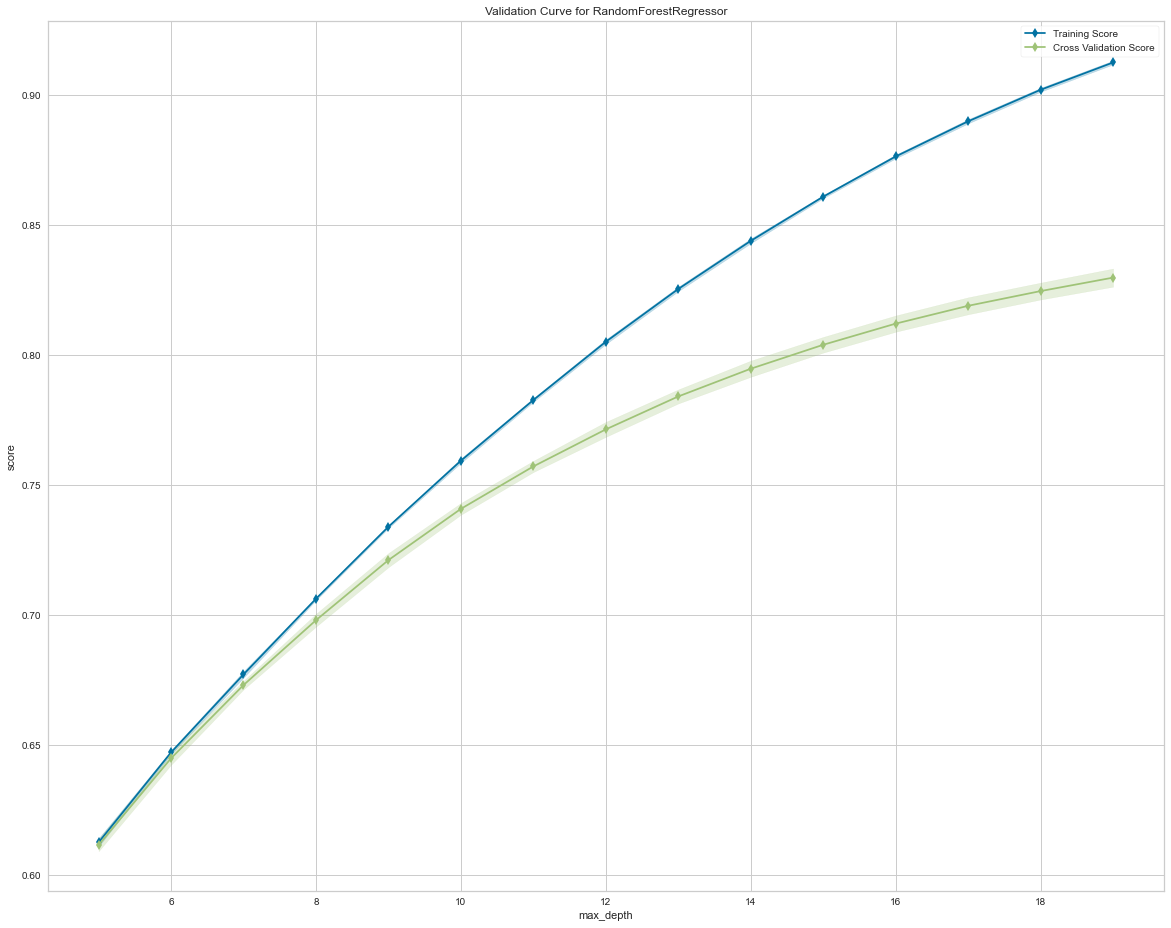

In [41]:
plot_validation_curves('max_depth', np.arange(5, 20), x_train_preprocessed, y_train_preprocessed)

Neste primeiro plot em que temos a profundidade máxima da árvore vemos que o modelo aumenta a acurácia conforme aumentamos a profundidade das árvores, mas também percebe-se que a curva de treino e teste vão se afastando, indicando a tendência da floresta aleatória de overfitting.

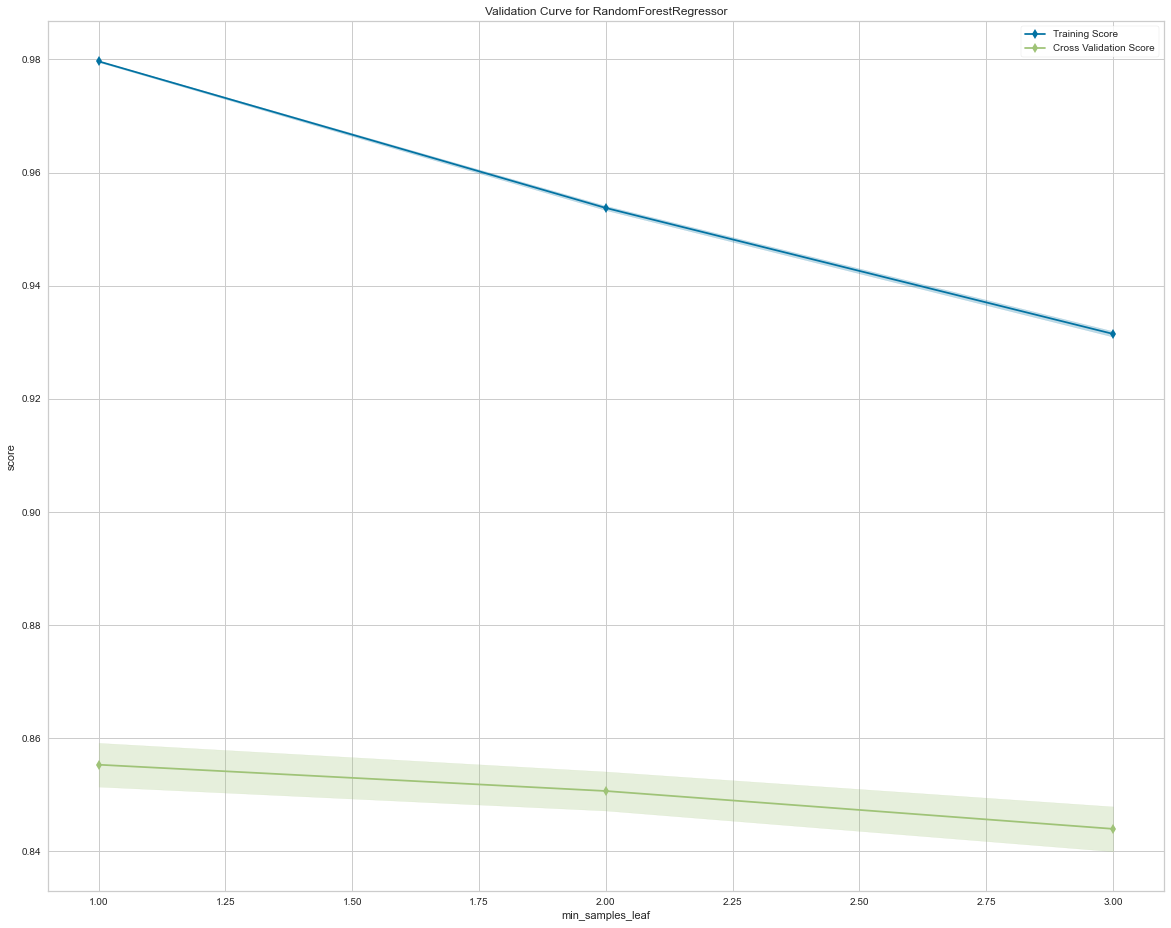

In [36]:
plot_validation_curves('min_samples_leaf', np.arange(1, 10), x_train_preprocessed, y_train_preprocessed)

Quanto ao min_samples_leaf vemos que o ideal é 1, já que acima disso há uma piora no score tanto para o treino quando para o teste.

A curva de aprendizado no aprendizado de máquina é usada para avaliar como os modelos se comportarão com diferentes números de amostras de treinamento. Isso é alcançado monitorando as pontuações de treinamento e validação (precisão do modelo) com um número crescente de amostras de treinamento.O gráfico abaixo representa um modelo que possui uma grande diferença entre a precisão do treinamento e a precisão da validação. A precisão do treinamento é maior do que a precisão da validação. Esse modelos sofrem de alta variância (overfitting).

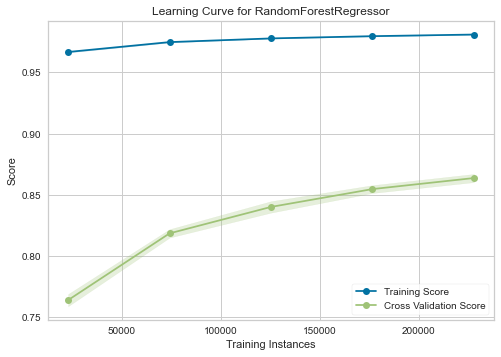

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [38]:
from yellowbrick.model_selection import(LearningCurve)
lc3_viz = LearningCurve(RandomForestRegressor(n_estimators=100),
                        cv=5)
lc3_viz.fit(x_train_preprocessed, y_train_preprocessed)
lc3_viz.poof()

In [17]:
n_estimators = [10,30,35,50,100]
max_depth = [int(x) for x in np.linspace(10, 220, num = 11)]
max_depth.append(None)
max_features = ['sqrt','auto']
min_samples_leaf = [1,2,5]
min_samples_split = [ 2, 5, 7, 10]
bootstrap = [True, False]
grid_params = {
    
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'bootstrap' : bootstrap
    }

print(grid_params)

{'n_estimators': [10, 30, 35, 50, 100], 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 199, 220, None], 'max_features': ['sqrt', 'auto'], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 5, 7, 10], 'bootstrap': [True, False]}


In [14]:
r2_rfe = []
MAE_rfe = []
RMSE_rfe = []
MAD_rfe = []

rfe_grid = RandomizedSearchCV(RandomForestRegressor(), grid_params, random_state=42)

start = time.time()
count = 0

n_splits = 3

kf = KFold(n_splits=n_splits)

for train, test in kf.split(x_train_preprocessed, y_train_preprocessed):
    fold_start = time.time()  # Início do tempo do fold
    
    # Ajuste o modelo aos dados de treinamento
    model_rf = rfe_grid.fit(x_train_preprocessed[train], y_train_preprocessed[train])
        
    # Selecione o melhor estimador do RandomizedSearchCV
    best_est_rf = rfe_grid.best_estimator_
    
    # Faça previsões no conjunto de teste
    prediction_rf = best_est_rf.predict(x_train_preprocessed[test])
    
    # Adicione as métricas de avaliação às suas respectivas listas
    r2_rfe.append(r2_score(y_train_preprocessed[test], prediction_rf))
    MAE_rfe.append(mean_absolute_error(y_train_preprocessed[test], prediction_rf))
    RMSE_rfe.append(np.sqrt(mean_squared_error(y_train_preprocessed[test], prediction_rf)))
    MAD_rfe.append(np.mean(np.abs(y_train_preprocessed[test] - prediction_rf)))
    
    count = count + 1
    print(f"K-fold nº: {count}")
    
    # Imprima a duração do fold atual
    fold_end = time.time()
    fold_duration = (fold_end - fold_start) / 60  # Duração do fold em minutos
    print(f"Duração do fold: {fold_duration:.1f} minutos")
    print()
    
    # Imprima os melhores hiperparâmetros para o modelo Random Forest

print('---' * 20)
print(f"Melhores estimadores para Random Forest: {rfe_grid.best_params_}")

# Imprima a média das métricas de avaliação em todos os folds
print('---' * 20)
print('Resultados')
print(f"R2 Score:  {np.mean(r2_rfe)}")
print(f"MAE:       {np.mean(MAE_rfe)}")
print(f"RMSE:      {np.mean(RMSE_rfe)}")
print(f"MAD:       {np.mean(MAD_rfe)}")
print('---' * 20)

# Imprima o tempo total de validação cruzada

end = time.time()
total_time = (end - start) / 60  # Tempo total em minutos
print(f"Tempo total da validação cruzada: {total_time:.1f} minutos")


K-fold nº: 1
Duração do fold: 62.6 minutos

K-fold nº: 2
Duração do fold: 70.3 minutos

K-fold nº: 3
Duração do fold: 68.2 minutos

------------------------------------------------------------
Melhores estimadores para Random Forest: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}
------------------------------------------------------------
Resultados
R2 Score:  0.848161085865895
MAE:       0.018722792872195474
RMSE:      0.03764974783428442
MAD:       0.018722792872195474
------------------------------------------------------------
Tempo total da validação cruzada: 201.0 minutos


In [18]:
r2_rfe = []
MAE_rfe = []
RMSE_rfe = []
MAD_rfe = []

rfe_grid = RandomizedSearchCV(RandomForestRegressor(), grid_params, random_state=42)

start = time.time()
count = 0

n_splits = 3

kf = KFold(n_splits=n_splits)

for train, test in kf.split(x_train_preprocessed, y_train_preprocessed):
    fold_start = time.time()  # Início do tempo do fold
    
    # Ajuste o modelo aos dados de treinamento
    model_rf = rfe_grid.fit(x_train_preprocessed[train], y_train_preprocessed[train])
        
    # Selecione o melhor estimador do RandomizedSearchCV
    best_est_rf = rfe_grid.best_estimator_
    
    # Faça previsões no conjunto de teste
    prediction_rf = best_est_rf.predict(x_train_preprocessed[test])
    
    # Adicione as métricas de avaliação às suas respectivas listas
    r2_rfe.append(r2_score(y_train_preprocessed[test], prediction_rf))
    MAE_rfe.append(mean_absolute_error(y_train_preprocessed[test], prediction_rf))
    RMSE_rfe.append(np.sqrt(mean_squared_error(y_train_preprocessed[test], prediction_rf)))
    MAD_rfe.append(np.mean(np.abs(y_train_preprocessed[test] - prediction_rf)))
    
    count = count + 1
    print(f"K-fold nº: {count}")
    
    # Imprima a duração do fold atual
    fold_end = time.time()
    fold_duration = (fold_end - fold_start) / 60  # Duração do fold em minutos
    print(f"Duração do fold: {fold_duration:.1f} minutos")
    print()
    
    # Imprima os melhores hiperparâmetros para o modelo Random Forest

print('---' * 20)
print(f"Melhores estimadores para Random Forest: {rfe_grid.best_params_}")

# Imprima a média das métricas de avaliação em todos os folds
print('---' * 20)
print('Resultados')
print(f"R2 Score:  {np.mean(r2_rfe)}")
print(f"MAE:       {np.mean(MAE_rfe)}")
print(f"RMSE:      {np.mean(RMSE_rfe)}")
print(f"MAD:       {np.mean(MAD_rfe)}")
print('---' * 20)

# Imprima o tempo total de validação cruzada

end = time.time()
total_time = (end - start) / 60  # Tempo total em minutos
print(f"Tempo total da validação cruzada: {total_time:.1f} minutos")


K-fold nº: 1
Duração do fold: 44.2 minutos

K-fold nº: 2
Duração do fold: 43.0 minutos

K-fold nº: 3
Duração do fold: 37.2 minutos

------------------------------------------------------------
Melhores estimadores para Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 136, 'bootstrap': False}
------------------------------------------------------------
Resultados
R2 Score:  0.8568639990883625
MAE:       0.018185426363833784
RMSE:      0.03655657662667434
MAD:       0.018185426363833784
------------------------------------------------------------
Tempo total da validação cruzada: 124.5 minutos


# Modelo Final

Eu  testei várias combinaçãos de hiperparâmetros e ainda assim não consegui melhorar o modelo para performar melhor que o modelo original. Aparentemente, o fator que mais influencia na capacidade de performance do modelo é diretamente influenciada pelo max_depth. Por motivos computacionais, não consegui tunar os hiperparamêtros de maneira mais eficiente. Isso é um trabalho que pode ser feito posteriormente.

O modelo final, portanto será uma floresta aleatória com os parâmetros originais.

In [11]:
rfr_model = RandomForestRegressor()  
rfr_results = cross_validation(rfr_model, x_train_preprocessed, y_train_preprocessed)


Média geral do R2: 0.8631819842783581
Média geral da MAE: 0.016669298240264755
Média geral do RMSE: 0.03573690935256549
Média geral da MAD: 0.016669298240264755


# Previsão

Com o modelo final já treinado e com as devidas métricas podemos utiliza-lo para os dados de teste e assim ver o quão bem ele generaliza para dados novos:

In [ ]:
# Fazer previsões na base de teste
predictions = rfr_model.predict(x_test_preprocessed)

In [13]:


# Avaliar as previsões
r2_test = r2_score(y_test_preprocessed, predictions)
mae_test = mean_absolute_error(y_test_preprocessed, predictions)
rmse_test = np.sqrt(mean_squared_error(y_test_preprocessed, predictions))
mad_test = np.mean(np.abs(y_test_preprocessed - predictions))

# Exibir os resultados
print('---' * 20)
print('Resultados Finais')
print(f'R2 na base de teste: {r2_test}')
print(f'MAE na base de teste: {mae_test}')
print(f'RMSE na base de teste: {rmse_test}')
print(f'MAD na base de teste: {mad_test}')
print('---' * 20)


------------------------------------------------------------
Resultados Finais
R2 na base de teste: 0.8602731851970433
MAE na base de teste: 0.016668844632657647
RMSE na base de teste: 0.03599250619671259
MAD na base de teste: 0.016668844632657647
------------------------------------------------------------
